In [36]:
import numpy as np
import os
import pandas as pd
from helper_functions import calculate_results

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import tensorflow_hub as hub

import random

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [37]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

In [38]:
def get_lines(filename):
    with open(filename, "r") as f:
        return f.readlines()

Visualising training sentences

In [39]:
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

We observe that every new abstract begins with an id, starting with a "###".
Also, at the end of every abstract, there is a "\n".
The target and text for every line are separated by "\t".

So, let's write a function that will preprocess these abstracts and return to us a DataFrame revealing certain features of it.

In [40]:
def preprocess_text_with_line_numbers(filename):
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines:
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.splitlines()

            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split("\t")
                line_data["target"] = target_text_split[0]
                line_data["text"] = target_text_split[1].lower()
                line_data["line_number"] = abstract_line_number
                line_data["total_lines"] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)

        else:
            abstract_lines += line
    return abstract_samples

In [41]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 246 ms, sys: 92.1 ms, total: 338 ms
Wall time: 453 ms


(180040, 30212, 30135)

In [42]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


<AxesSubplot:xlabel='target', ylabel='count'>

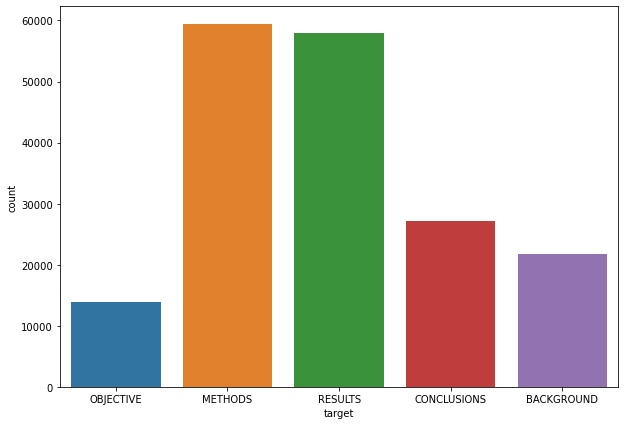

In [43]:
plt.figure(figsize=(10,7))
sns.countplot(train_df.target)

In [44]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

Now let's encode our target labels.

In [45]:
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [46]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [47]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

<h3>Creating models

<h5>Baseline model involving Naive-Baye's

In [48]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [49]:
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [50]:
baseline_preds = model_0.predict(val_sentences)

baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

<h5>Model_1 based upon token and character level embedding

Here we will create embeddings for tokens and characters. We will use Unviersal Sentence Encoder for token level encoding and Tensorflow's TextVectorizer for char level encoding.

<h4>Token Encoding

In [51]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
output_seq_len = int(np.percentile(sent_lens, 95))
max_tokens=68000

In [52]:
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-07-09 18:54:29.103021: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-09 18:54:29.104727: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-07-09 18:54:33.002374: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-09 18:54:33.029933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [53]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
however , only exercise improved muscle strength and balance .



2022-07-09 18:54:34.048469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Sentence after embedding:
[ 0.02023723 -0.06655328 -0.04662736  0.04446952 -0.0239982   0.08206777
 -0.01637951  0.0041658  -0.00413393  0.08133954 -0.04421332  0.03309486
 -0.01464748 -0.01830733  0.04156832  0.05579033 -0.04290242 -0.03267976
  0.06991226  0.02285956  0.08189807  0.04624748 -0.02950945  0.01741698
  0.05157929 -0.00722864 -0.04421993  0.01478398  0.03570337 -0.04676574] (truncated output)...

Length of sentence embedding:
512


<h4>Character level embedding

In [54]:
def split_chars(text):
    return " ".join(list(text))

In [55]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [56]:
output_seq_char_len = int(np.percentile([len(char_sent) for char_sent in train_sentences], 95))
output_seq_char_len

290

In [57]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
NUM_CHAR_TOKENS = len(alphabet) + 2 #space and OOV token
char_vectorizer = TextVectorization(max_tokens = NUM_CHAR_TOKENS, output_sequence_length = output_seq_char_len, standardize="lower_and_strip_punctuation", name="char_vectorizer")
char_vectorizer.adapt(train_chars)

2022-07-09 18:54:36.442595: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [58]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [59]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, output_dim=25, mask_zero=False, name="char_embed")

In [60]:
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_output)

char_input = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_input)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs = char_input, outputs = char_bi_lstm)

token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(200, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)

output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

model_1 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output_layer, name="model_1_token_char_embeddings")

model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [61]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [62]:
%%time
# Fit the model on tokens and chars
model_1_history = model_1.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3


2022-07-09 18:54:45.433459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 18:54:45.778189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 18:54:45.849648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 18:54:46.699444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 18:54:46.716049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


562/562 [==============================] - ETA: 0s - loss: 0.9471 - accuracy: 0.6222

2022-07-09 18:56:11.295034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 18:56:11.485740: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 18:56:11.493596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


562/562 [==============================] - 99s 169ms/step - loss: 0.9471 - accuracy: 0.6222 - val_loss: 0.7904 - val_accuracy: 0.6975
Epoch 2/3
562/562 [==============================] - 100s 177ms/step - loss: 0.7691 - accuracy: 0.7024 - val_loss: 0.7245 - val_accuracy: 0.7271
Epoch 3/3
562/562 [==============================] - 103s 183ms/step - loss: 0.7423 - accuracy: 0.7152 - val_loss: 0.6965 - val_accuracy: 0.7364
CPU times: user 4min 31s, sys: 1min 26s, total: 5min 57s
Wall time: 5min 1s


In [63]:
model_1_pred_probs = model_1.predict(val_char_token_dataset)
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

2022-07-09 18:59:45.559379: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 18:59:45.812758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 18:59:45.823179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


945/945 [==============================] - 109s 114ms/step


{'accuracy': 73.59658413875282,
 'precision': 0.7342370422782746,
 'recall': 0.7359658413875282,
 'f1': 0.7333548687980066}

<h3>Model_2: Char and Token Embeddings + Positional Embedding

Moving on with our previous model, we can see that every abstract has a specific order of components. For example, OBJECTIVE of any abstract will come before RESULT. We can leverage this property and use it as another input to feed our model.

In [64]:
train_df.line_number.value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

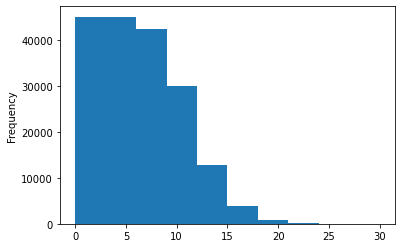

In [65]:
train_df.line_number.plot.hist();

In [66]:
train_line_numbers_one_hot = tf.one_hot(train_df.line_number.to_numpy(), depth = 15)
val_line_numbers_one_hot = tf.one_hot(val_df.line_number.to_numpy(), depth = 15)
test_line_numbers_one_hot = tf.one_hot(test_df.line_number.to_numpy(), depth = 15)

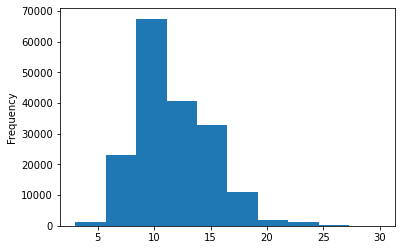

In [67]:
train_df.total_lines.plot.hist();

In [68]:
np.percentile(train_df.total_lines, 98)

20.0

In [69]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

In [70]:
%%time
# 1. Token Inputs
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs, outputs=token_outputs)

# 2. Char Inputs
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Line number inputs
line_number_inputs = layers.Input(shape=(15,), dtype=tf.int32, name="line_number_input")
x = layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs= line_number_inputs, outputs=x)

# 4. Total Lines inputs
total_lines_inputs = layers.Input(shape=(20,), dtype=tf.int32, name="total_lines_input")
y = layers.Dense(32, activation="relu")(total_lines_inputs)
total_lines_model = tf.keras.Model(inputs=total_lines_inputs, outputs=y)

# 5. Combining token and char embeddings
combined_embeddings = layers.Concatenate(name = "token_char_hybrid_embedding")([token_model.output, char_model.output])
z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embeddings with combined token and char embeddings into a tribid embedding
z = layers.Concatenate(name="token_char_positional_embedding")([line_number_model.output, total_lines_model.output, z])

output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(z)

model_2 = tf.keras.Model(inputs=[line_number_model.input, total_lines_model.input, token_model.input, char_model.input], outputs = output_layer)

model_2.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

CPU times: user 411 ms, sys: 92.2 ms, total: 504 ms
Wall time: 626 ms


In [71]:
%%time
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot, train_total_lines_one_hot, train_sentences, train_chars))

train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data, train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              val_sentences,
                                                              val_chars))
val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data, val_pos_char_token_labels))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

CPU times: user 669 ms, sys: 245 ms, total: 914 ms
Wall time: 1.61 s


In [72]:
# Fit the token, char and positional embedding model
# %%time
history_model_2 =model_2.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3


2022-07-09 19:01:39.782006: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 19:01:40.227502: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 19:01:40.241157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 19:01:41.435143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 19:01:41.451718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


562/562 [==============================] - ETA: 0s - loss: 1.0948 - accuracy: 0.7228

2022-07-09 19:03:32.545680: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 19:03:32.804990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 19:03:32.830249: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


562/562 [==============================] - 132s 225ms/step - loss: 1.0948 - accuracy: 0.7228 - val_loss: 0.9884 - val_accuracy: 0.8032
Epoch 2/3
562/562 [==============================] - 130s 231ms/step - loss: 0.9659 - accuracy: 0.8149 - val_loss: 0.9522 - val_accuracy: 0.8268
Epoch 3/3
562/562 [==============================] - 134s 238ms/step - loss: 0.9493 - accuracy: 0.8226 - val_loss: 0.9415 - val_accuracy: 0.8291


In [73]:
%%time
model_2_pred_probs = model_2.predict(val_pos_char_token_dataset, verbose=1)
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

2022-07-09 19:08:14.431461: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 19:08:14.979929: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-09 19:08:15.135429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


945/945 [==============================] - 136s 142ms/step
CPU times: user 2min 8s, sys: 42.8 s, total: 2min 51s
Wall time: 2min 16s


{'accuracy': 83.26161790017211,
 'precision': 0.8321396124575425,
 'recall': 0.8326161790017211,
 'f1': 0.8313881816156524}